# Molecular Dynamics Simulation of Thermalization

## Introduction
This code simulates the thermalization of a system of particles undergoing elastic collisions. It models a **2D gas** where particles are initially divided into two populations:
- **Hot particles** with a higher initial temperature
- **Cold particles** with a lower initial temperature

As the simulation progresses, particles collide and exchange energy, leading to **thermal equilibration**. The key observables in this simulation include:
1. **Kinetic energy evolution of labeled particles**
2. **Histogram of kinetic energy distributions before and after thermalization** (now with a log-linear plot)
3. **Velocity distributions before and after thermalization**, compared to the **normalized 2D Maxwell-Boltzmann distribution**
4. **An animated visualization of particle dynamics** (optimized for inline rendering in Jupyter Book)

## Physical Model
Each particle follows **Newtonian mechanics**, moving freely until it collides with a wall or another particle. 

### **Hard-Sphere Collision Model**
Particles are modeled as **hard spheres**, meaning their interactions follow **elastic collision laws**:
- Momentum and kinetic energy are conserved.
- Collisions with walls are perfectly elastic.
- **Particle-particle collisions are explicitly handled** using momentum and energy conservation equations.

### **Initial Conditions**
- Particles are assigned **random positions** within a box.
- Half of the particles are initialized with **higher kinetic energy** (hot particles), while the other half have **lower kinetic energy** (cold particles).
- A small subset of particles is **labeled** for tracking.

### **Thermalization Process**
As time progresses, the energy distribution evolves due to collisions, approaching a **Boltzmann distribution**. The final kinetic energy distribution should follow an **exponential distribution**, characteristic of a system in thermal equilibrium.

## Implementation Details
- **Elastic collisions** are detected and handled via velocity updates.
- **Hard-sphere interactions** are included to ensure realistic thermalization.
- **Kinetic energy tracking** is performed for labeled hot and cold particles.
- **Animation subsampling** is implemented to reduce memory overhead.
- **Histograms** show the initial and final kinetic energy distributions, now also in a **log-linear plot**.
- **Velocity distributions are plotted and compared to the properly normalized 2D Maxwell-Boltzmann distribution**.

## Visualization and Outputs
1. **Inline animation** of particle motion (compatible with Jupyter Book, avoids external windows).
2. **Time series plots** of kinetic energy for labeled particles (rendered inline in Jupyter Book).
3. **Histograms of kinetic energy distributions** before and after equilibration, including a **log-linear plot**.
4. **Velocity distributions before and after thermalization**, with an overlay of the **normalized 2D Maxwell-Boltzmann distribution**.

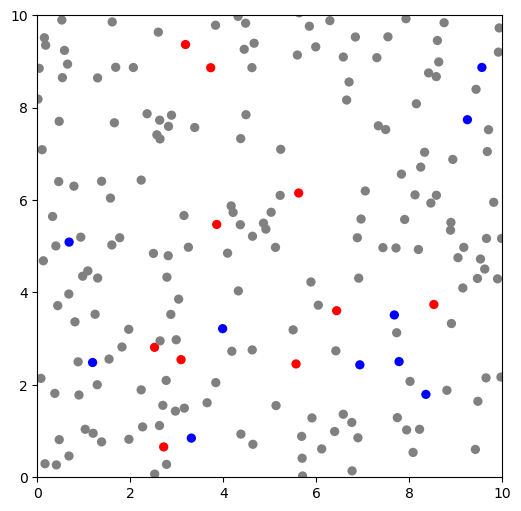

In [43]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
#matplotlib.use('Agg') 

# Simulation parameters
N = 200  # Total number of particles
m = 20    # Number of labeled particles
L = 10.0 # Box size
T_hot = 10.0  # Temperature of hot particles
T_cold = 0.0  # Temperature of cold particles
dt = 0.01 # Time step
steps = 200  # Increased number of simulation steps
subsample_rate = 3  # Reduce memory by updating animation every 10 steps
radius = 0.1  # Particle radius for collisions

# Initialize particle properties
np.random.seed(42)
pos = np.random.rand(N, 2) * L  # Random positions

# Ensure particles are not overlapping initially
for i in range(N):
    for j in range(i + 1, N):
        while np.linalg.norm(pos[i] - pos[j]) < 2 * radius:
            pos[j] = np.random.rand(2) * L  # Relocate if overlapping

# Divide population into hot and cold
half_N = N // 2
vel = np.zeros((N, 2))
vel[:half_N] = np.random.randn(half_N, 2) * np.sqrt(T_hot)  # Hot particles
vel[half_N:] = np.random.randn(half_N, 2) * np.sqrt(T_cold)  # Cold particles

velini = vel.copy()

# Choose labeled particles from both groups
labeled_hot = np.random.choice(range(half_N), m//2, replace=False)
labeled_cold = np.random.choice(range(half_N, N), m//2, replace=False)
labeled_indices = np.concatenate((labeled_hot, labeled_cold))

# Track the kinetic energy of labeled particles
time_series = {i: [] for i in labeled_indices}

def compute_collisions(pos, vel, L):
    """Detects and handles collisions with walls and between particles."""
    for i in range(N):
        for dim in range(2):
            if pos[i, dim] <= 0 or pos[i, dim] >= L:
                vel[i, dim] *= -1  # Elastic collision with walls
    
    # Particle-particle collisions
    for i in range(N):
        for j in range(i + 1, N):
            dist = np.linalg.norm(pos[i] - pos[j])
            if dist < 2 * radius:  # Hard-sphere collision condition
                normal = (pos[j] - pos[i]) / dist
                v1n = np.dot(vel[i], normal)
                v2n = np.dot(vel[j], normal)
                v1t = vel[i] - v1n * normal
                v2t = vel[j] - v2n * normal
                vel[i] = v2n * normal + v1t  # Swap normal velocity components
                vel[j] = v1n * normal + v2t
    return vel

# Visualization setup
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
colors = ['red' if i in labeled_hot else 'blue' for i in labeled_indices]
particles = [plt.Circle(pos[i], radius, fc=colors[labeled_indices.tolist().index(i)] if i in labeled_indices else 'gray') for i in range(N)]
for p in particles:
    ax.add_patch(p)

def update(frame):
    """Update particle positions in animation with subsampling."""
    global pos, vel
    for _ in range(subsample_rate):  # Advance simulation subsample_rate steps per frame
        pos += vel * dt  # Update positions
        vel = compute_collisions(pos, vel, L)  # Handle collisions
        for i in labeled_indices:
            kinetic_energy = 0.5 * np.linalg.norm(vel[i])**2
            time_series[i].append(kinetic_energy)
    for i, p in enumerate(particles):
        p.set_center(pos[i])
    return particles

ani = animation.FuncAnimation(fig, update, frames=steps // subsample_rate, blit=False, interval=10)
HTML(ani.to_jshtml())  # Ensure inline animation in Jupyter Book




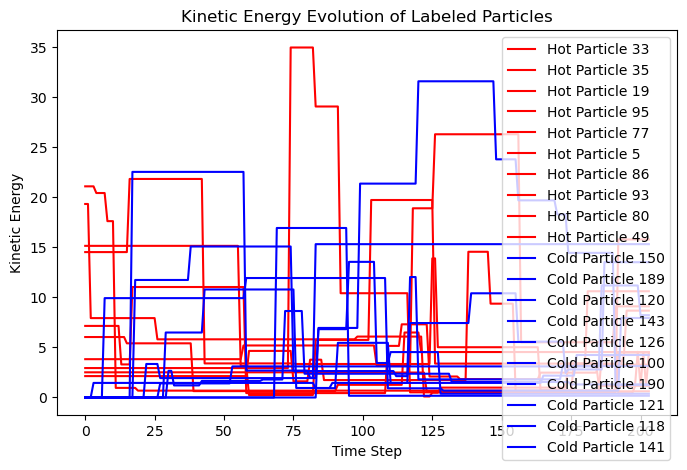

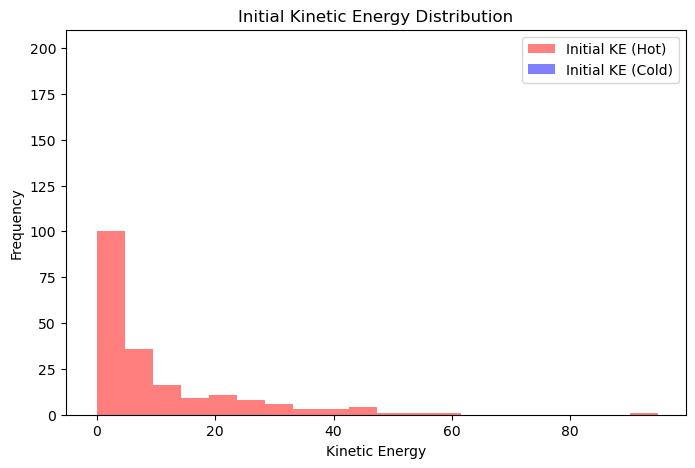

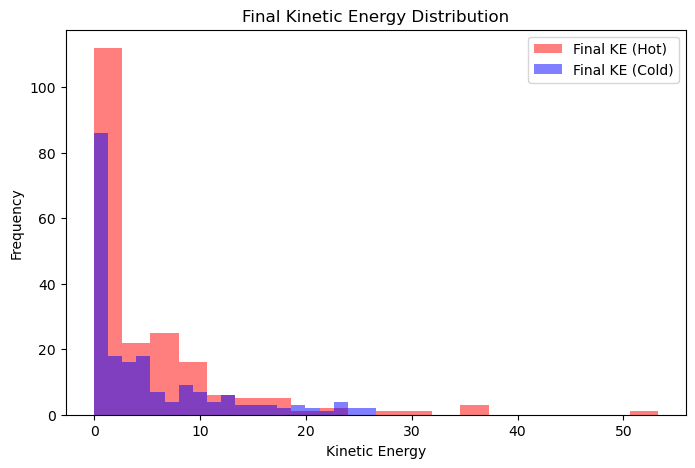

In [44]:
# Plot kinetic energy time series inline
%matplotlib inline
plt.figure(figsize=(8, 5))
for i in labeled_hot:
    plt.plot(time_series[i], color='red', label=f'Hot Particle {i}')
for i in labeled_cold:
    plt.plot(time_series[i], color='blue', label=f'Cold Particle {i}')
plt.xlabel('Time Step')
plt.ylabel('Kinetic Energy')
plt.title('Kinetic Energy Evolution of Labeled Particles')
plt.legend()
plt.show()

# Plot the kinetic energy histograms inline
plt.figure(figsize=(8, 5))
plt.hist(velini[:half_N].flatten()**2, bins=20, alpha=0.5, color='red', label='Initial KE (Hot)')
plt.hist(velini[half_N:].flatten()**2, bins=20, alpha=0.5, color='blue', label='Initial KE (Cold)')
plt.xlabel('Kinetic Energy')
plt.ylabel('Frequency')
plt.title('Initial Kinetic Energy Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist(vel[:half_N].flatten()**2, bins=20, alpha=0.5, color='red', label='Final KE (Hot)')
plt.hist(vel[half_N:].flatten()**2, bins=20, alpha=0.5, color='blue', label='Final KE (Cold)')
plt.xlabel('Kinetic Energy')
plt.ylabel('Frequency')
plt.title('Final Kinetic Energy Distribution')
plt.legend()
plt.show()

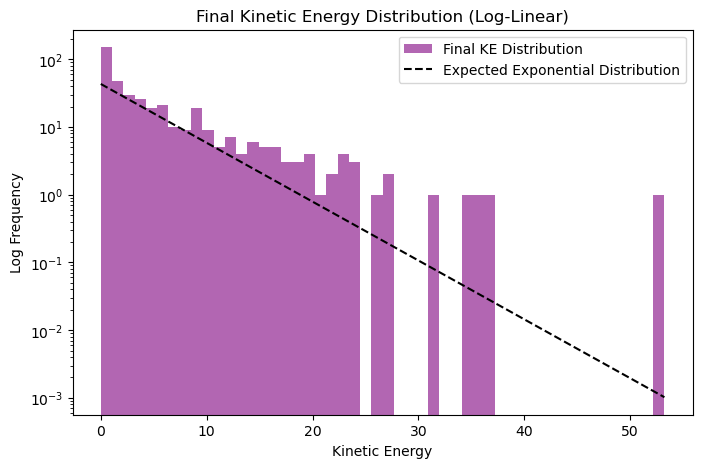

In [45]:
%matplotlib inline
# Plot the kinetic energy histogram on a log-linear scale
plt.figure(figsize=(8, 5))
ke_values = np.concatenate((vel[:half_N].flatten()**2, vel[half_N:].flatten()**2))
plt.hist(ke_values, bins=50, alpha=0.6, color='purple', label='Final KE Distribution', log=True)

# Expected final distribution (Exponential distribution of KE over thermal energy)
T_final = (T_hot + T_cold) / 2
ke_expected = np.linspace(0, max(ke_values), 100)
exp_distribution = (1 / T_final) * np.exp(-ke_expected / T_final) * len(ke_values) * np.mean(np.diff(ke_expected))
plt.plot(ke_expected, exp_distribution, 'k--', label='Expected Exponential Distribution')

plt.xlabel('Kinetic Energy')
plt.ylabel('Log Frequency')
plt.title('Final Kinetic Energy Distribution (Log-Linear)')
plt.legend()
plt.show()

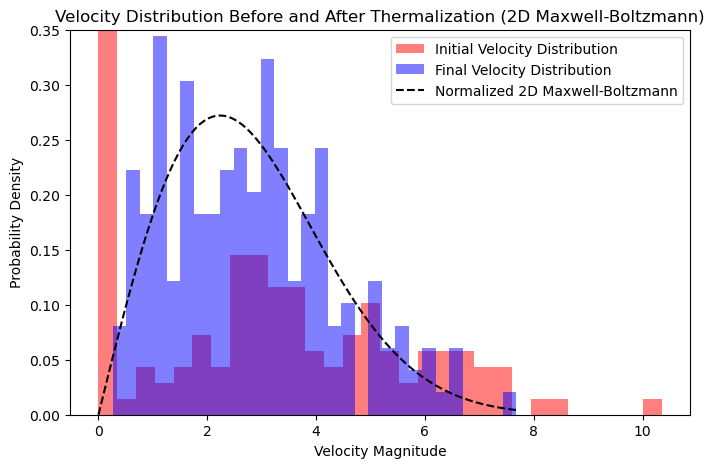

: 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell

# Compute velocity magnitudes before and after thermalization
vel_initial = np.linalg.norm(velini, axis=1)
vel_final = np.linalg.norm(vel, axis=1)

# Properly normalized 2D Maxwell-Boltzmann distribution
T_final = (T_hot + T_cold) / 2  # Final temperature assumption
v_range = np.linspace(0, np.max(vel_final), 100)
mb_distribution_2d = (v_range / T_final) * np.exp(-v_range**2 / (2 * T_final))
mb_distribution_2d /= np.trapz(mb_distribution_2d, v_range)  # Normalize the distribution

# Plot velocity distributions before and after thermalization
plt.figure(figsize=(8, 5))
plt.hist(vel_initial, bins=30, alpha=0.5, color='red', label='Initial Velocity Distribution', density=True)
plt.hist(vel_final, bins=30, alpha=0.5, color='blue', label='Final Velocity Distribution', density=True)
plt.plot(v_range, mb_distribution_2d, 'k--', label='Normalized 2D Maxwell-Boltzmann')

plt.xlabel('Velocity Magnitude')
plt.ylabel('Probability Density')
plt.title('Velocity Distribution Before and After Thermalization (2D Maxwell-Boltzmann)')
plt.legend()
plt.ylim(0,0.35)
plt.show()